<div class="alert alert-danger" role="alert">
    <span style="font-size:20px">&#9888;</span> <span style="font-size:16px">This is a read-only notebook! If you want to make and save changes, save a copy by clicking on <b>File</b> &#8594; <b>Save a copy</b>. If this is already a copy, you can delete this cell.</span>
</div>

<h1>PDF extraction of complex tables<span class="tocSkip"></span></h1>

**This notebook shows examples of extracting PDF tables that are not on a specific page, may span multiple pages, and lack column dividers** 

This uses the pdfplumber library, and we apply it to individual investment advisor filings from the SEC, which is public information: https://adviserinfo.sec.gov/ (see the PDF named "individual_7290241.pdf" in the sample_input folder)

The filings follow the same structure, but size and location of tables vary based on the individual's job experience. We have two examples:
- Extracting the "Registrations" (which in this example spans pages 4-5)
- Extracting the "Employment History" (which in this example is located on page 7)

Our approach in this examples involves identifying the coordinates of the text / numbers in the table to determine the rows and columns of the table. This works well since the table contents are left aligned.

**The methodology used in Section 3 is more straightforward than that in Section 2**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<ul class="toc-item"><li><span><a href="#Loading-in-the-PDF-data" data-toc-modified-id="Loading-in-the-PDF-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading in the PDF data</a></span></li><li><span><a href="#Extract-Registrations" data-toc-modified-id="Extract-Registrations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Extract Registrations</a></span><ul class="toc-item"><li><span><a href="#Create-utility-functions" data-toc-modified-id="Create-utility-functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create utility functions</a></span></li><li><span><a href="#Logic-for-looping-through-pages-to-find-all-registration-tables-and-all-sections-of-each-such-table,-and-putting-them-into-a-single-dataframe" data-toc-modified-id="Logic-for-looping-through-pages-to-find-all-registration-tables-and-all-sections-of-each-such-table,-and-putting-them-into-a-single-dataframe-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Logic for looping through pages to find all registration tables and all sections of each such table, and putting them into a single dataframe</a></span></li></ul></li><li><span><a href="#Extract-Employment-History" data-toc-modified-id="Extract-Employment-History-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extract Employment History</a></span><ul class="toc-item"><li><span><a href="#Create-utility-functions" data-toc-modified-id="Create-utility-functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create utility functions</a></span></li><li><span><a href="#Logic-for-looping-through-pages-to-find-all-sections-of-the-table-and-putting-it-into-a-single-dataframe" data-toc-modified-id="Logic-for-looping-through-pages-to-find-all-sections-of-the-table-and-putting-it-into-a-single-dataframe-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Logic for looping through pages to find all sections of the table and putting it into a single dataframe</a></span></li></ul></li></ul>

**We begin by importing basic libraries for data handling and pdf extraction**

In [1]:
import pandas as pd
import pdfplumber

On a windows machine, you would need additional pre-requisities in order to get an image of table being identified: 
- https://docs.wand-py.org/en/latest/guide/install.html#install-imagemagick-on-windows

# Loading in the PDF data


In [2]:
pdf = pdfplumber.open("sample_input/individual_3163621.pdf")

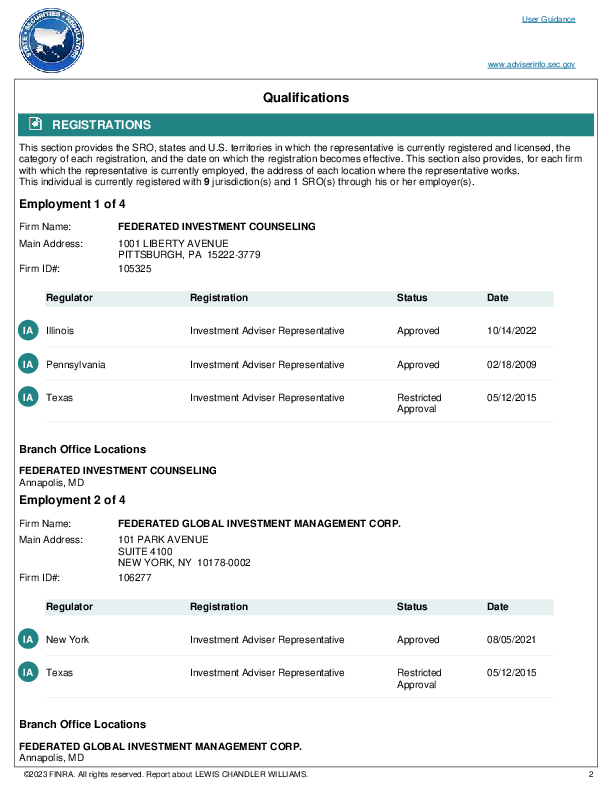

In [3]:
# Preview the pages (change the index to view the specific page)
pdf.pages[3].to_image()

# Extract Registrations

For each current job the financial advisor holds, there is one table listing their registrations for that job. Most advisors have only 1 current employment, but some have more than 1. Therefore, multiple tables of the same kind is searched for. 

## Create utility functions

**This table is one of the first tables of the document, so we will start from the second page (first page is the cover page) when looking for the table**

In [4]:
def get_page_order(pdf):
    max_page = len(pdf.pages)
    page_order = list(range(2,max_page-1))
    
    return page_order

**The following function will combine words into a long string**

In [5]:
def get_text(words):
    word_list = []
    for word in words:
        word_list.append(word['text'].strip())
    return " ".join(word_list)

**Function to identify the coordinates for the tables (rows and columns of the table)**

This code also attempts to identify the start of the table, end of the table, and whether that is the definite end of the table. Since the start of the table is identified by the first header, we will be able to identify continuations of the table 

Refer to comments within the function below for more information

In [6]:
def get_table_splits(words, check_for_immediate_end = False, stop_searching_before = None):
    
    # check_for_immediate_end: If the table may have stopped last page, check up front if end of the table has been found on this page
    # stop_searching_before: The first 2 words indicating that the next table has been found 
    
    vertical_split = [] # List storing the x-coordinates for vertical borders 
    horizontal_split = [] # List storing the y-coordinates for horizontal borders
    found_start = False # Indicator for finding the start of the table on the page
    found_end = False # Indicator for finding the end of the table on the page
    is_start = False # Indicator for whether the current row is the first row of the table
    
    row_text = [] # List of all words in this row
    row_x0 = [] # List of y-coordinates associated with this row
    current_top = -1 # This will hold the y-coordinate of the text in the current row

    idx = 0 # Index for counting the words while iterating
    for idx, word in enumerate(words): # Loop through all the words identified. Each word comes with information about the coordinates
        
        # Find new row
        if word['top'] > current_top + 5:  # If the top of the current word is at least 5 more than the prior top, we have found a new row
            
            # End prior row
            if found_start: # If the table has started
                if is_start: # If currently at the first row of the table
                    horizontal_split.append(current_top) # We have found the first horizontal border
                else: # If not at the first row of the table
                    if (row_text[0] != "") & (row_text[0] != "Approval"): # If the first cell is not blank, then we have found a row of the table
                        horizontal_split.append(current_top)
            if found_end: # If end of the table has been found
                horizontal_split.append(current_top) # Add the coordinates of the last horizontal border and stop searching
                break 
            elif word['text'].strip()[0] == "©": # If the table ends at the very bottom of the page, there would be a copyright mark denoting the end of the table
                horizontal_split.append(word['top'])
                break
            if is_start: # If this is the first row of the table, find the left-most border of each column and add it to the vertical splits
                break_names = ["regulator", "registration", "status", "date"]
                vertical_split = [x0_location+0.1 for word, x0_location in zip(row_text, row_x0) if word.lower() in break_names]
                is_start = False
            
            # Start new row
            row_text = []
            row_x0 = []
            current_top = word['top']
            
        # Add to row
        row_text.append(str(word['text']))
        row_x0.append(word['x0'])
        
        # Logic for identifying beginning and end of the table
        
        # If table for the next employment is found before rows for prior table is found, return nothing for the prior table
        if stop_searching_before and (len(row_text) == 2):
            if "|".join(row_text).lower() == stop_searching_before:
                return None, None, True, words[idx:] # Return remaining words to search for next table
        
        # Alternative check for the end of this table (caused by branch location of current employment being found)
        if check_for_immediate_end & (not found_start) & (len(row_text) == 2):
            # Check end of table
            if "|".join(row_text).lower() == "branch|office":
                return None, None, True, words[idx:] # Return remaining words to search for next table
        
        # If table hasn't yet been found, check whether this row is the start of a new table 
        if (not found_start) & (len(row_text) == 2):
            # Check if start of table
            if "|".join(row_text).lower() == "regulator|registration":
                found_start = True
                is_start = True
                
        # If table has been found, check if this row is the end of this table
        if (found_start) & (len(row_text) == 2):        
            # Check end of table
            if "|".join(row_text).lower() == "branch|office":
                found_end = True
        
        # If table hasn't been found, but we found the text expected after this table
        if (not found_start) & (len(row_text) == 2):        
            # Check end of table, but haven't found start (i.e. table ended at bottom of last page)
            if "|".join(row_text).lower() == "branch|office":
                return None, None, True, [] # Return blank table
    
    # IF table was never found
    if not found_start:
        return None, None, False, [] 
    
    # Return the coordinates for vertical borders, horizontal borders, and whether the true end of the table was found (rather than just end of the page)
    return vertical_split, horizontal_split, found_end, words[idx:]


## Logic for looping through pages to find all registration tables and all sections of each such table, and putting them into a single dataframe

Checking page: 2
Checking page: 3
Searching for table starting within page
Found table for employment #1 within page


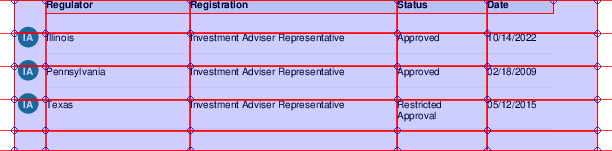

Searching for table starting within page
Found table for employment #2 within page


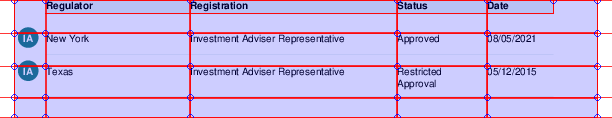

Checking page: 4
Searching for table starting within page
Found table for employment #3 within page


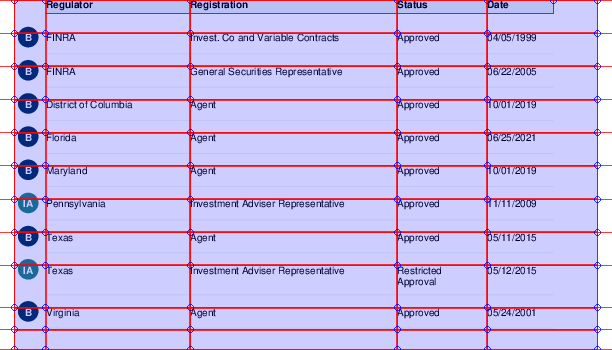

Searching for table starting within page
Checking page: 5
Searching for table at top of page
Found table for employment #4 at top of page


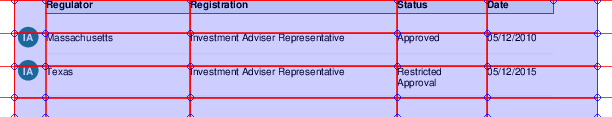

Checking page: 6
Checking page: 7


,IA/B,Regulator,Registration,Status,Date,employment_index
0,IA,Illinois,Investment Adviser Representative,Approved,2022-10-14,1
1,IA,Pennsylvania,Investment Adviser Representative,Approved,2009-02-18,1
2,IA,Texas,Investment Adviser Representative,RestrictedApproval,2015-05-12,1
3,IA,New York,Investment Adviser Representative,Approved,2021-08-05,2
4,IA,Texas,Investment Adviser Representative,RestrictedApproval,2015-05-12,2
5,B,FINRA,Invest. Co and Variable Contracts,Approved,1999-04-05,3
6,B,FINRA,General Securities Representative,Approved,2005-06-22,3
7,B,District of Columbia,Agent,Approved,2019-10-01,3
8,B,Florida,Agent,Approved,2021-06-25,3
9,B,Maryland,Agent,Approved,2019-10-01,3


In [7]:
debug = True # Debug mode to print found tables

# List of table segments
tables = []

# Get the order to check for employment history
pages = get_page_order(pdf)

# Indicators for what to check for (start of existing table, continuation of table on next page, etc.)
check_for_start_of_table = True
look_for_table = True
look_for_table_continuation = False
table_starts_page = False

# Employment count (most people have only one current employment)
current_id = 1

# Loop through the pages
for page in pages:
    if debug: print(f"Checking page: {page}")
    
    # Multiple tables may be on the same page, so we provide the page specific count of tables
    count_on_page = 0

    # Extract words from the page
    this_page = pdf.pages[page]
    words = this_page.extract_words()

    # Join all words into a long string
    all_text = "|".join([word['text'].lower() for word in words])

    # Find if page should contain table
    continue_loop = True
    while continue_loop:

        if check_for_start_of_table:
                
            # If we expect a table to begin at the top of the page (e.g. continuation from prior page's table)
            if table_starts_page:
                if debug: print(f"Searching for table at top of page")
            
                table_starts_page = False
                
                # Get table from this page
                vertical_split, horizontal_split, found_end, words = get_table_splits(words, stop_searching_before = "employment|{}".format(current_id+1))
                if vertical_split is None:
                    # Unable to find start of table
                    current_id += 1
                    check_for_start_of_table = True
                    look_for_table_continuation = False
                    continue_loop = True # Move to next table on this page
                    continue
                
                if debug: print(f"Found table for employment #{current_id} at top of page")
                
            # If not, check for table starting within this page
            elif ("qualifications|" in all_text) & ("employment|{}".format(current_id) in all_text):
                
                if debug: print(f"Searching for table starting within page")
            
                check_for_start_of_table = False
                
                # Get table from this page
                vertical_split, horizontal_split, found_end, words = get_table_splits(words)

                if (vertical_split is None) and (horizontal_split is None):
                    # No table found. Either:
                    
                    # Found the next employment starting on this page
                    if ("qualifications|" in all_text) & ("employment|{}".format(current_id+1) in all_text):
                        current_id += 1
                        check_for_start_of_table = True
                        look_for_table_continuation = False
                        continue_loop = True # Move to next table on this page
                        continue
                    
                    # Or, next employment is not on this page (or doesn't exist). 
                    else: 
                        check_for_start_of_table = True
                        table_starts_page = True
                        look_for_table_continuation = False
                        continue_loop = False # Move to next page
                        continue
                    
                if debug: print(f"Found table for employment #{current_id} within page")
                # A new table found, and therefore added
                count_on_page += 1

                # Determine whether to check for continuation or next table
                if found_end:
                    check_for_start_of_table = True
                    look_for_table_continuation = False
                else:
                    look_for_table_continuation = True
                    continue_loop = False

            else:
                # Did not find the intended table
                break

        # Looking for the continuation of a prior page's table that hasn't ended
        elif look_for_table_continuation:
            
            if debug: print(f"Checking whether table continues on following page")
            
            vertical_split, horizontal_split, found_end, words = get_table_splits(words, count_on_page == 0)

            # Found end of table immediately. No data on this page
            if (count_on_page == 0) & found_end:
                current_id += 1
                check_for_start_of_table = True
                look_for_table_continuation = False
                continue
            
            # For other reason, found no table
            if (vertical_split is None) and (horizontal_split is None):
                current_id += 1
                check_for_start_of_table = True
                look_for_table_continuation = False
                continue_loop = False
                continue
            
            if debug: print(f"Found continuation of table for employment #{current_id}")
            
            # Check for next table
            if found_end:
                check_for_start_of_table = True
                look_for_table_continuation = False
            else:
                look_for_table_continuation = True
                continue_loop = False

        # Parse table
        if len(vertical_split) != 4:
            vertical_split = default_vertical_split  # If the PDF didn't have 4 columns, use the default column locations
        else:
            default_vertical_split = vertical_split  # If the PDF had 4 columns, then use these as new default locations (in case the PDF is different)

        # An additional column with IA or B should also be found
        croppage = this_page.crop((0, horizontal_split[0], this_page.width, horizontal_split[-1]))

        horizontal_split[-1] = horizontal_split[-1]-20

        if debug:
            im = croppage.to_image()   # For debugging only. This requires additional programs to be installed
            display(im.debug_tablefinder({"explicit_horizontal_lines": horizontal_split, 
                                          "explicit_vertical_lines": vertical_split, 
                                          "snap_tolerance": 4,
                                          "horizontal_strategy": "explicit"}))

        table = croppage.extract_table(table_settings={"explicit_horizontal_lines": horizontal_split, 
                                                      "explicit_vertical_lines": vertical_split, 
                                                      "snap_tolerance": 4,
                                                      "horizontal_strategy": "explicit"})

        table_df = pd.DataFrame(table[1:], columns=["IA/B", "Regulator", "Registration", "Status", "Date"])
        table_df = table_df[~(table_df['Regulator'].fillna("")=="")].reset_index(drop=True)
        table_df["employment_index"] = current_id
        tables.append(table_df)

        if found_end:
            current_id += 1
            check_for_start_of_table = True
            look_for_table_continuation = False

if len(tables) > 0:
    formatted_table = pd.concat(tables).reset_index(drop=True)
else:
    raise ValueError("Could not find formatted table")

# Remove linebreak
for colname in ['IA/B', "Regulator", "Registration", "Status"]:
    formatted_table[colname] = formatted_table[colname].str.replace("\n"," ")

def format_date(x):
    if x == "Unknown":
        return None
    else:
        return pd.to_datetime(x).date()

# Format dates
formatted_table['Date'] = pd.to_datetime(formatted_table['Date'].str.split("-").str[0].str.strip()).dt.date

formatted_table

# Extract Employment History

The start of the Employment History table is identified by finding the header row starting with "Employment Dates"

## Create utility functions

**This table is one of the last tables of the document, so we will start from the second to last page first, and go forward until we find the start of the table**

In [8]:
def get_page_order(pdf):
    max_page = len(pdf.pages)
    page_order = list(range(1,max_page-1))
    page_order.reverse()
    
    return page_order


**The following function will combine words into a long string**

In [9]:
def get_text(words):
    word_list = []
    for word in words:
        word_list.append(word['text'].strip())
    return " ".join(word_list)

**Function to identify the coordinates for the tables (rows and columns of the table)**

This code also attempts to identify the start of the table, end of the table, and whether that is the definite end of the table. Since the start of the table is identified by the first header, we will be able to identify continuations of the table 

Refer to comments within the function below for more information

In [10]:
def get_table_splits(words):
    
    vertical_split = [] # List storing the x-coordinates for vertical borders 
    horizontal_split = [] # List storing the y-coordinates for horizontal borders
    found_start = False # Indicator for finding the start of the table on the page
    found_end = False # Indicator for finding the end of the table on the page
    is_start = False # Indicator for whether the current row is the first row of the table
    
    row_text = [] # List of all words in this row
    row_x0 = [] # List of y-coordinates associated with this row
    current_top = -1 # This will hold the y-coordinate of the text in the current row
    for word in words: # Loop through all the words identified. Each word comes with information about the coordinates
        # Find new row
        if word['top'] > current_top + 3:  # If the top of the current word is at least 3 more than the prior top, we have found a new row
            # End prior row
            if found_start: # If the table has started
                if is_start: # If currently at the first row of the table
                    horizontal_split.append(current_top) # We have found the first horizontal border
                else: # If not at the first row of the table
                    try: 
                        if pd.to_datetime(row_text[0]): # Check if the row starts with a date (which we expect given the contents of the table)
                            horizontal_split.append(current_top) # If it is a date (rather than blank or something else), this is a new row of the table, and thus we record the horizontal border of this row
                    except:
                        pass
            if found_end: # If found the end of the table, add the last horizontal split, and then stop looking for more words / rows
                horizontal_split.append(current_top)
                break 
            elif word['text'].strip()[0] == "©": # If the table ends at the very bottom of the page, there would be a copyright mark denoting the end of the table
                horizontal_split.append(word['top'])
                break
            if is_start: # If this is the first row of the table, find the left-most border of each column and add it to the vertical splits
                break_names = ["employment", "employer", "position", "investment", "employer"]
                vertical_split = [x0_location+0.1 for word, x0_location in zip(row_text, row_x0) if word.lower() in break_names]
                is_start = False
            
            # Start new row
            row_text = []
            row_x0 = []
            current_top = word['top']
            
        # Add text to the row
        row_text.append(str(word['text']))
        row_x0.append(word['x0'])
        
        # Logic for identifying beginning and end of the table
        if (not found_start) & (len(row_text) == 2):
            # Check if start of table
            if "|".join(row_text).lower() == "employment|dates":
                found_start = True
                is_start = True
        if (found_start) & (len(row_text) == 2):        
            # Check end of table
            if "|".join(row_text).lower() == "other|business": # Other Business starts the section below the table (unless the table ends at bottom of the page)
                found_end = True
        if (not found_start) & (len(row_text) == 2):        
            # Check end of table, but haven't found start (i.e. table ended at bottom of last page)
            if "|".join(row_text).lower() == "other|business":
                return None, None, True
    
    # Return the coordinates for vertical borders, horizontal borders, and whether the true end of the table was found (rather than just end of the page)
    return vertical_split, horizontal_split, found_end 

## Logic for looping through pages to find all sections of the table and putting it into a single dataframe

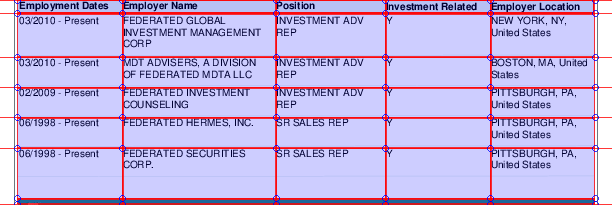

C:\Users\daniel.wang\AppData\Local\Temp\ipykernel_96840\2701900579.py:97: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  formatted_table[colname] = formatted_table[colname].str.replace("|"," ")


,Employment Dates,Employer Name,Position,Investment Related,Employer Location,StartDate,EndDate
0,03/2010 - Present,FEDERATED GLOBAL INVESTMENT MANAGEMENT CORP,INVESTMENT ADV REP,Y,"NEW YORK, NY, United States",2010-03-01,
1,03/2010 - Present,"MDT ADVISERS, A DIVISION OF FEDERATED MDTA LLC",INVESTMENT ADV REP,Y,"BOSTON, MA, United States",2010-03-01,
2,02/2009 - Present,FEDERATED INVESTMENT COUNSELING,INVESTMENT ADV REP,Y,"PITTSBURGH, PA, United States",2009-02-01,
3,06/1998 - Present,"FEDERATED HERMES, INC.",SR SALES REP,Y,"PITTSBURGH, PA, United States",1998-06-01,
4,06/1998 - Present,FEDERATED SECURITIES CORP.,SR SALES REP,Y,"PITTSBURGH, PA, United States",1998-06-01,


In [11]:
debug = True # Debug mode to check tables

tables = [] # List containing dataframes of all relevant table sections

# Get the order of pages to be traversed
pages = get_page_order(pdf)

# Indicator for whether the table has been found
found_table = False

# Loop through each page
for page in pages:
    this_page = pdf.pages[page]
    words = this_page.extract_words() # Extract the words from the page
    
    # Identify the definite start of the table in the whole document (not just the start of the table within a page)
    if "Below is the representative's employment history for up to the last 10 years" in get_text(words):
        found_table = True
        break

# Didn't find the table in the whole document. Stop the code
if found_table == False:
    raise ValueError("Did Not Find Table")

# Create an indicator for finding the definite end of the table
found_end_of_table = False

# While end of the table hasn't been found, loop through the pages
while (found_end_of_table == False) & (page <= len(pages)):

    # Find table
    vertical_split, horizontal_split, found_end = get_table_splits(words)
    
    # If didn't find any coordinates, then there is no table on this page, and the table must have ended at the bottom of last page (coincidentally)
    if (vertical_split is None) and (horizontal_split is None):
        found_end_of_table = True
        break

    croppage = this_page.crop((0, horizontal_split[0], this_page.width, horizontal_split[-1]))
    
    if debug:
        im = croppage.to_image()   # For debugging only. This requires additional programs to be installed
        display(im.debug_tablefinder({"explicit_horizontal_lines": horizontal_split, 
                                               "explicit_vertical_lines": vertical_split, 
                                               "snap_tolerance": 4}))

    # Retrieve table
    table = croppage.extract_table(table_settings={"explicit_horizontal_lines": horizontal_split, 
                                                   "explicit_vertical_lines": vertical_split, 
                                                   "snap_tolerance": 4})

    # Convert to Pandas and set column names
    temp_table = pd.DataFrame(table[1:], columns=['Employment Dates', 'Employer Name', 'Position', 'Investment Related', 'Employer Location']) #table[0])

    # Check if the top row is overall blank
    temp_table_NA = temp_table.fillna("")
    if len(tables) > 0:
        first_row = temp_table_NA.loc[0]
        if all(first_row[['Employment Dates', "Investment Related"]] == "") and any(first_row[['Employer Name', 'Position', 'Employer Location']] != ""):
            last_table = tables[-1]

            if first_row['Employer Name'] != "":
                last_table.iloc[-1]["Employer Name"] = str(last_table.iloc[-1]["Employer Name"]) + " " + str(first_row['Employer Name'])
            if first_row['Position'] != "":
                last_table.iloc[-1]["Position"] = str(last_table.iloc[-1]["Position"]) + " " + str(first_row['Position'])
            if first_row['Employer Name'] != "":
                last_table.iloc[-1]["Employer Location"] = str(last_table.iloc[-1]["Employer Location"]) + " " + str(first_row['Employer Location'])

            tables[-1] = last_table

    tables.append(temp_table.loc[temp_table_NA['Employment Dates'] != ""].copy())

    if found_end:
        found_end_of_table = True
    else:
        page += 1
        this_page = pdf.pages[page]
        words = this_page.extract_words()

if found_end_of_table is False:
    raise ValueError("Found table, but could not find the end of the table")

if len( tables ) >= 1:
    formatted_table = pd.concat(tables).reset_index(drop=True)

else:
    # Create a dummy employment record
    d = { 'Employment Dates':'01/1901 - Present', 'Employer Name':'', 'Position':'', 'Investment Related':'', 'Employer Location':'' }
    formatted_table = pd.DataFrame( d, index=[0] )

# Remove linebreak
for colname in ['Employer Name', "Position", "Employer Location"]:
    formatted_table[colname] = formatted_table[colname].str.replace("\n"," ")

# Remove vertical line (pipe)
for colname in ['Employer Name', "Position", "Employer Location"]:
    formatted_table[colname] = formatted_table[colname].str.replace("|"," ")

# Format the date column
def format_date(x):
    if x == "Present" or x == "Unknown":
        return ""
    else:
        return pd.to_datetime(x).date()
    
# Format dates
formatted_table['StartDate'] = formatted_table['Employment Dates'].str.split("-").str[0].str.strip().apply( lambda x: format_date(x) )
formatted_table['EndDate']   = formatted_table['Employment Dates'].str.split("-").str[-1].str.strip().apply( lambda x: format_date(x) )

formatted_table